In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/MyDrive/Inżynierka/Dane/test.zip'

In [ ]:
import torch
import os
import torch.nn as nn
import cv2
import numpy as np
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F

import time
import torchvision

from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics

In [ ]:
# Funkcje pomocnicze
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [ ]:
data_path = '/content/test'

classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

In [ ]:
%cd /content/drive/MyDrive/Inżynierka/Collab/pytorch

/content/drive/MyDrive/MojePliki/Inżynierka/Collab/pytorch


In [ ]:
model_paths = []
model_dirs = ['ResNet']

for model_dir in model_dirs:
    for filep in os.listdir(model_dir):
        if filep.endswith("pth"):
            model_paths.append(model_dir+'/'+filep)

In [ ]:
faceCascade = cv2.CascadeClassifier('FaceDetection/haarcascade_frontalface_default.xml')

In [ ]:
from PIL import Image

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def predict_image(path, model, detect_face=False):
  img = Image.open(path).convert('RGB')
  img = np.asarray(img)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if detect_face:
    faces = faceCascade.detectMultiScale(
      gray,
      scaleFactor=1.1,
      minNeighbors=5,
      minSize=(30, 30))
    img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in faces:
      #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
      img = img[y:y+h, x:x+w]

  preprocess = tt.Compose([tt.Resize((64,64)),
                         tt.Grayscale(num_output_channels=1),
                         tt.ToTensor()])

  img_preprocessed = preprocess(Image.fromarray(img))
  batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
  out = model(batch_img_tensor)
  _, index = torch.max(out, 1)
  return index.item()

In [ ]:
test_tfms = tt.Compose([tt.Resize((64,64)),
                         tt.Grayscale(num_output_channels=1),
                         tt.ToTensor()])

test_ds = ImageFolder('/content/test', test_tfms)

test_dl = DataLoader(test_ds, 490, num_workers=1, pin_memory=True)

#test_dl = DeviceDataLoader(test_dl, device) # dla GPU

In [ ]:
def compute_metrics(model_paths, data_path, compare_face_detection=True):
    string1 = 'single prediction time (' + '490' + ' files)'
    string2 = 'batch prediction time (' + '490' + ' files)'
    metrics = [['model', 'face detection', 'model load time', 'single prediction time (one file)', string1, string2, 'accuracy', 'precision', 'f1 score', 'ROC AUC', 'confusion matrix']]
    
    onceortwice = 1
    if compare_face_detection:
        onceortwice += 1
       
    for model_path in model_paths:
      for i in range(onceortwice):
        if i==0:
          face=False
        if i==1:
          face=True
                
        print("Evaluating ", model_path, "...", " (FACE DETECTION)" if face else ' (NO FACE DETECTION)', sep="")
                
        row = []
        row.append(model_path)
        row.append(face)
            
        if i==0:
            print("Loading model...")
            start_time = time.time()
            model = torch.load(model_path)
            load_time = time.time() - start_time
            row.append(load_time)
        if i==1:
            print("Model already loaded.")
            row.append("-")

        y_true = []
        y_pred = []
        pred_times = []
        print("Making predictions on single files...")
        model.eval()
        for c in classes:
          folder_path = os.path.join(data_path, c)
          files = os.listdir(folder_path)
          files.sort()
          for filename in files:
            if filename.endswith(".png"):
              start_time = time.time()
              y_pred.append(predict_image(os.path.join(folder_path,filename), model = model, detect_face=face))
              y_true.append(classes.index(c))
              pred_time = time.time() - start_time
              pred_times.append(pred_time)

        row.append(np.mean(pred_times))
        row.append(sum(pred_times))
            
        print("Making predictions on all files...")
        start_time = time.time()
        out = evaluate(model, test_dl)
        pred_time = time.time() - start_time
        row.append(pred_time)

        print("Calculating metrics...")
        enc = OneHotEncoder(sparse = False)
        one_hot_pred = enc.fit_transform(np.array(y_pred).reshape(-1, 1))
        one_hot_true = enc.fit_transform(np.array(y_true).reshape(-1, 1))

        acc = sklearn.metrics.accuracy_score(y_true, y_pred)
        prec = sklearn.metrics.precision_score(y_true, y_pred, average='weighted')
        f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
        roc_auc = sklearn.metrics.roc_auc_score(one_hot_true, one_hot_pred, average='weighted')
        conf = sklearn.metrics.confusion_matrix(y_true, y_pred)

        row.append(acc)
        row.append(prec)
        row.append(f1)
        row.append(roc_auc)
        row.append(conf)
        
        metrics.append(row)
            
    return metrics

In [ ]:
metrics = compute_metrics(model_paths, data_path)
metrics

In [ ]:
np.savetxt('metrics.csv', metrics, delimiter=',', fmt='%s')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
confm1 = metrics[1][10]
confm1 = np.round(confm1/70*100, 1)
confm1

array([[ 85.7,   0. ,   0. ,   0. ,   2.9,  11.4,   0. ],
       [ 84.3,   5.7,   0. ,   0. ,   1.4,   8.6,   0. ],
       [ 37.1,   0. ,  37.1,   2.9,   1.4,  18.6,   2.9],
       [  0. ,   0. ,   0. , 100. ,   0. ,   0. ,   0. ],
       [ 20. ,   0. ,   0. ,   0. ,  64.3,  15.7,   0. ],
       [ 20. ,   0. ,   0. ,   0. ,   5.7,  74.3,   0. ],
       [  8.6,   0. ,  12.9,   0. ,   5.7,   1.4,  71.4]])

In [ ]:
confm2 = metrics[1][10]
confm2 = np.round(confm2/70*100, 1)
confm2

array([[ 85.7,   0. ,   0. ,   0. ,   2.9,  11.4,   0. ],
       [ 84.3,   5.7,   0. ,   0. ,   1.4,   8.6,   0. ],
       [ 37.1,   0. ,  37.1,   2.9,   1.4,  18.6,   2.9],
       [  0. ,   0. ,   0. , 100. ,   0. ,   0. ,   0. ],
       [ 20. ,   0. ,   0. ,   0. ,  64.3,  15.7,   0. ],
       [ 20. ,   0. ,   0. ,   0. ,   5.7,  74.3,   0. ],
       [  8.6,   0. ,  12.9,   0. ,   5.7,   1.4,  71.4]])

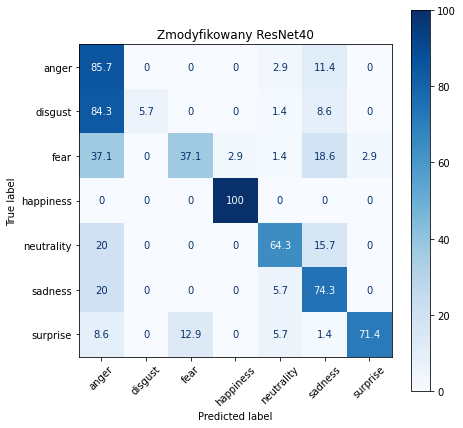

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm1,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("Zmodyfikowany ResNet40")
plt.show()

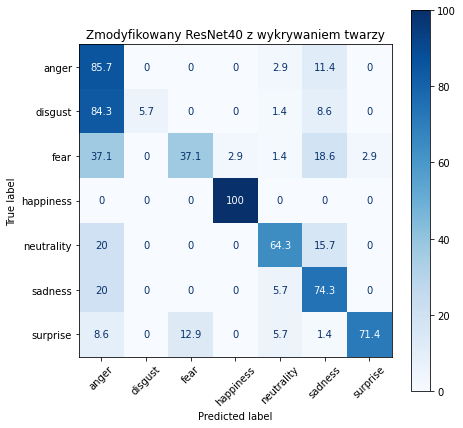

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm2,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("Zmodyfikowany ResNet40 z wykrywaniem twarzy")
plt.show()

Testowanie

In [ ]:
np.__version__

'1.19.5'

In [ ]:
torch.__version__

'1.10.0+cu111'

In [ ]:
torchvision.__version__

'0.11.1+cu111'